# Analyzing Museum Types in Capital Cities

### Importing libraries

In [2]:
import pandas as pd
import requests
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
mpl.style.use(['seaborn'])
import seaborn as sns
sns.set()


# Step 1

### Setting up API 

In [19]:
# Foursquare API credentials and endpoint
CLIENT_ID = 'IOA5YBXOBJVEC4MN4SWHAVNCSU1QEBCMURQOGNRT0ZYFMZUT'

# your client ID
CLIENT_SECRET = 'IIHNVIZLDC0MZZGEY3GA1HMGQQKYXO2YLGOVVIR1UEBQ1IIY'

# your client secret
VERSION = '20210118' # put today's date
URL = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION, 5000)


### Obtain list of capital cities from Github 

In [20]:
# List of capital cities to be explored
cities_csv=pd.read_csv("https://raw.githubusercontent.com/icyrockcom/country-capitals/master/data/country-list.csv")
cities_csv=pd.DataFrame(cities_csv)
cities=[]
for i in range(len(cities_csv)):
        cities.append(cities_csv.iloc[i,1]+", "+cities_csv.iloc[i,0])


### Data Retrieval

The following code has been borrowed in large part from: https://gist.github.com/gbarreiro/a7e94cc7332bda25ec182370d462b7af#file-bestcuisines_get_restaurants-py

In [23]:
# List of museum types (extracted from https://developer.foursquare.com/docs/build-with-foursquare/categories/)
museum_types = {
    'Art': '4bf58dd8d48988d18f941735', 
    'Erotic': '559acbe0498e472f1a53fa23', 
    'History': '4bf58dd8d48988d190941735',
    'Planetarium': '4bf58dd8d48988d192941735',
    'Science': '4bf58dd8d48988d191941735'
    }


museums = pd.DataFrame(columns=['City', 'Museum type', 'Number of museums']) # define the DataFrame where the results will be stored

for city in cities:
    for museum_type, category_id in museum_types.items():
        # For each city, retrieve museum types from Foursquare...
        query = requests.get("{url}&near={city}&categoryId={category_id}".format(url=URL, city=city, category_id=category_id))
        if query.status_code == 200:
            number = query.json()['response']['totalResults']
            museums = museums.append({
                'City': city,
                'Museum type': museum_type,
                'Number of museums': number
            }, ignore_index=True)

print(museums.head())


                City  Museum type Number of museums
0  Sukhumi, Abkhazia          Art                 0
1  Sukhumi, Abkhazia       Erotic                 0
2  Sukhumi, Abkhazia      History                 1
3  Sukhumi, Abkhazia  Planetarium                 0
4  Sukhumi, Abkhazia      Science                 0


# Step 2

### One-hot encoding


The following code has been borrowed in large part from:https://gist.github.com/gbarreiro/6fbffd04bb8c0cd81b99510437f6056b#file-bestcuisines_transform_data-py

In [24]:
# One-hot encoding
museums_onehot = pd.get_dummies(museums['Museum type'], prefix="", prefix_sep="")
museums_onehot = museums_onehot.multiply(museums['Number of museums'], axis=0)
museums_onehot = pd.concat([museums['City'], museums_onehot], axis=1)

# Group by city
museum_types_city = museums_onehot.groupby('City').sum().reset_index()
museum_types_city = museum_types_city.set_index(keys='City')

print(museum_types_city.head())



                             Art  Erotic  History  Planetarium  Science
City                                                                   
Abuja, Nigeria                 0       0        0            0        0
Accra, Ghana                   1       0        5            3        2
Adamstown, Pitcairn Islands    0       0        0            0        0
Addis Ababa, Ethiopia          1       0        6            0        0
Algiers, Algeria               4       0        7            0        0


### Normalisation

In [25]:
# Normalize the numbers
museum_types_city_normalized = museum_types_city.div(museum_types_city.sum(axis=1), axis=0)
museum_types_city_normalized = 100*museum_types_city_normalized

# Dropping NaN 
df=museum_types_city_normalized.dropna()

print(df.head())

                              Art     Erotic    History  Planetarium  \
City                                                                   
Accra, Ghana             9.090909   0.000000  45.454545    27.272727   
Addis Ababa, Ethiopia   14.285714   0.000000  85.714286     0.000000   
Algiers, Algeria        36.363636   0.000000  63.636364     0.000000   
Amman, Jordan           25.000000   0.000000  75.000000     0.000000   
Amsterdam, Netherlands  21.481481  33.333333  36.296296     4.444444   

                          Science  
City                               
Accra, Ghana            18.181818  
Addis Ababa, Ethiopia    0.000000  
Algiers, Algeria         0.000000  
Amman, Jordan            0.000000  
Amsterdam, Netherlands   4.444444  


# Step 3

## Obtain basic statistical properties of columns

### Pre-normalisation

In [26]:
print(museum_types_city.describe())


              Art      Erotic     History  Planetarium     Science
count  196.000000  196.000000  196.000000   196.000000  196.000000
mean     6.321429    0.464286   10.698980     1.127551    2.443878
std     14.179210    3.321067   19.765969     2.329093    4.613460
min      0.000000    0.000000    0.000000     0.000000    0.000000
25%      0.000000    0.000000    1.000000     0.000000    0.000000
50%      1.000000    0.000000    4.000000     0.000000    0.000000
75%      6.000000    0.000000    9.000000     1.000000    4.000000
max    118.000000   45.000000  158.000000    20.000000   37.000000


As can be seen above, history museums are the most common museum type around the world with an average of 10.7 histroy museums per city. Erotic, expectedly, is the least common with 0.5 per city, on average. 

### Which cities have the highest number of each museum type?

In order to find the cities with the highest amount of each specific type of musuem, idxmax from the pandas module was used to find the index.

In [42]:
museum_types_city.idxmax()

Art                      Tokyo, Japan
Erotic         Amsterdam, Netherlands
History                  Tokyo, Japan
Planetarium              Tokyo, Japan
Science                Moscow, Russia
dtype: object

Tokyo has the most Art and History museums as well as planetariums. Amsterdam, unsurprisingly has the most erotic museums and Moscow the most science museums.

### Which cities have the lowest number of each museum type?

In [88]:
museum_types_city.idxmin()

Art            Abuja, Nigeria
Erotic         Abuja, Nigeria
History        Abuja, Nigeria
Planetarium    Abuja, Nigeria
Science        Abuja, Nigeria
dtype: object

Abuja in Nigeria doesn't have any museums of the types used in this analysis.

In [27]:
museum_types_city.to_csv("/Users/datasandwich/Documents/GitHub/SDPA-CW/Part III/raw_data.csv")

### Post-normalisation

In [29]:
df.to_csv("/Users/datasandwich/Documents/GitHub/SDPA-CW/Part III/normalised_data.csv")

### Histograms of columns

In order to visualise the distribution of the data, histograms were plotted using the normalised data set:

array([[<AxesSubplot:title={'center':'Art'}>,
        <AxesSubplot:title={'center':'Erotic'}>],
       [<AxesSubplot:title={'center':'History'}>,
        <AxesSubplot:title={'center':'Planetarium'}>],
       [<AxesSubplot:title={'center':'Science'}>, <AxesSubplot:>]],
      dtype=object)

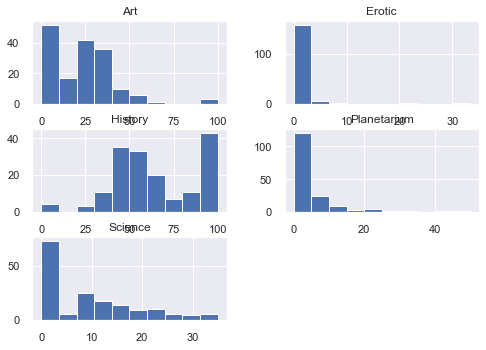

In [30]:
df.hist()

### Data distribution plot

In order to compare the distributions, seaborn was used to plot the distributions together.

/Users/datasandwich/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/datasandwich/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/datasandwich/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level func

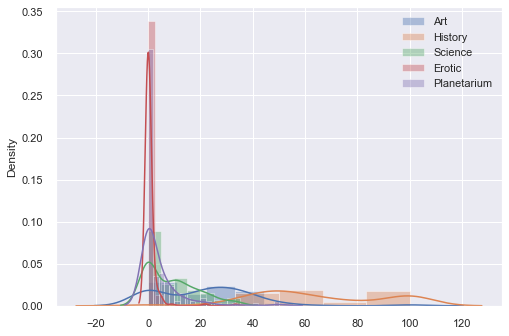

In [37]:
art=museum_types_city["Art"]
history=museum_types_city["History"]
science=museum_types_city["Science"]
erotic=museum_types_city["Erotic"]
planetarium=museum_types_city["Planetarium"]

art_norm=df["Art"]
history_norm=df["History"]
science_norm=df["Science"]
erotic_norm=df["Erotic"]
planetarium_norm=df["Planetarium"]

sns.distplot(pd.DataFrame(art_norm),label='Art')
sns.distplot(pd.DataFrame(history_norm),label='History')
sns.distplot(pd.DataFrame(science_norm),label='Science')
sns.distplot(pd.DataFrame(erotic_norm),label='Erotic')
sns.distplot(pd.DataFrame(planetarium_norm),label='Planetarium')
plt.legend()
plt.show()

### Removing extreme values to obtain a better visualisation of data distribution


new_art_norm=[]
new_history_norm=[]
new_science_norm=[]
new_erotic_norm=[]
new_planetarium_norm=[]

#Drop extreme values
for i in range(len(art_norm)):
    if (art_norm[i]!=0).any()==True:
        new_art_norm.append(art_norm[i])
    if (history_norm[i]!=100).any()==True:
        new_history_norm.append(history_norm[i])
    if (science_norm[i]!=0).any()==True:
        new_science_norm.append(science_norm[i])
    if (erotic_norm[i]!=0).any()==True:
        new_erotic_norm.append(erotic_norm[i])
    if (planetarium_norm[i]!=0).any()==True:
        new_planetarium_norm.append(planetarium_norm[i])

sns.distplot(pd.DataFrame(new_art_norm),label='Art')
sns.distplot(pd.DataFrame(new_history_norm),label='History')
sns.distplot(pd.DataFrame(new_science_norm),label='Science')
sns.distplot(pd.DataFrame(new_erotic_norm),label='Erotic')
sns.distplot(pd.DataFrame(new_planetarium_norm),label='Planetarium')
plt.legend()
plt.show()

### Is there a correlation between different museum types?

### Inter-column relationships (non-normalised)

In [58]:
museum_types_city.corr()


,Art,Erotic,History,Planetarium,Science
Art,1.000000,0.212440,0.924708,0.769582,0.877082
Erotic,0.212440,1.000000,0.252284,0.229652,0.176927
History,0.924708,0.252284,1.000000,0.796857,0.903511
Planetarium,0.769582,0.229652,0.796857,1.000000,0.752110
Science,0.877082,0.176927,0.903511,0.752110,1.000000


### Observations:

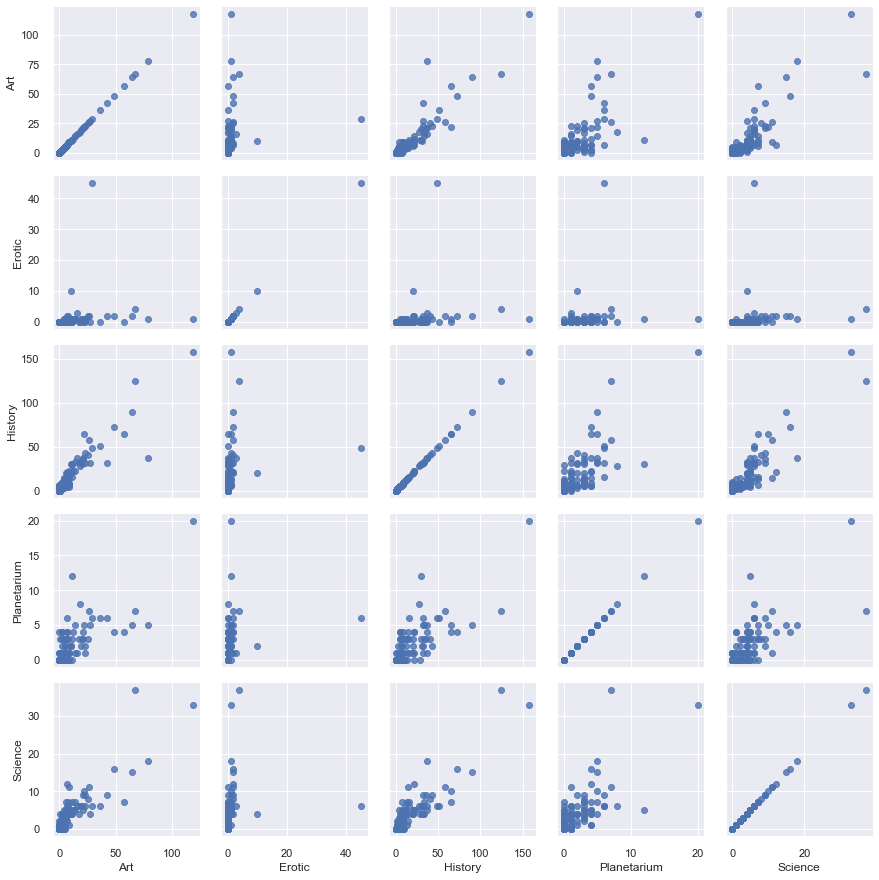

In [59]:
g = sns.PairGrid(museum_types_city, #vars=['Art', 'History', 'final_sec', 'split_frac'],
                 #hue='gender',
                 palette='RdBu_r')
g.map(plt.scatter, alpha=0.8)
#g.add_legend();

Art and history museums have a strong positive correlation. All other museum types exhibit weak positive correlations between each other with the exception of erotic cinemas which don't demonstrate correlations.

# Step 4

### Summary

The aim of this exploratory data analysis was to investigate museums in capital cities by type. The analysis has shown a strong positive correlation between art and history museums. Erotic museums don't have any correlation with other museum types. The correlation analysis also showed that Art is the most likely museum type to be found paired with any of the types. Art and history museum densities in capital cities across the world exhibit a quasi-normal distribution. Nigera was found to have no museums of any of the types using idxmin, however this approach makes it ambiguous whether there exist other cities without any museums. Japan has the highest number of top rankings among the museum categories, having the most art, history and planetarium musems. Moscow has the most science museum and of course Amsterdam has the most erotic museums.


### Future work

Expanding the data set to include continents so that musuem type density comparisons can be carried out